## `Import Libraries`

In [ ]:
! pip install -q keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.7 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

import tensorflow as tf
from kerastuner import RandomSearch

/tmp/ipython-input-711777683.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner import RandomSearch


## `Get the Dataset`

In [ ]:
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## `Exploratory Data Analysis`

In [ ]:
df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
df.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'sex', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [ ]:
# info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
# stats
df.describe()

,passengerid,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# check NaNs
df.isna().sum().sort_values(ascending=False)

,0
cabin,687
age,177
embarked,2
passengerid,0
name,0
pclass,0
survived,0
sex,0
parch,0
sibsp,0


In [ ]:
# Columns that has NaNs
cols_nans = df.isna().any()[df.isna().any()].index.tolist()
cols_nans

['age', 'cabin', 'embarked']

### `Visualizing`

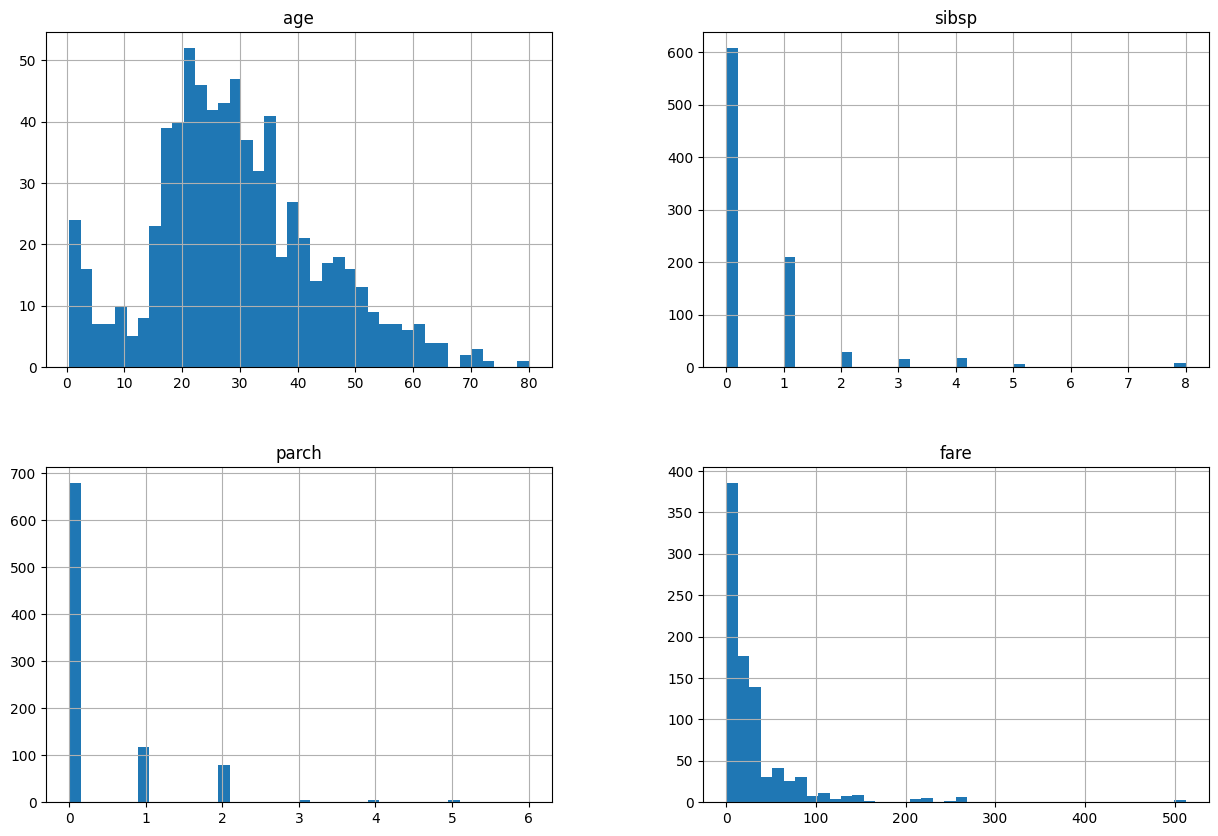

In [ ]:
# Numerical cols

num_cols = ['age', 'sibsp', 'parch', 'fare']
df[num_cols].hist(figsize=(15, 10), bins=40)
plt.show()

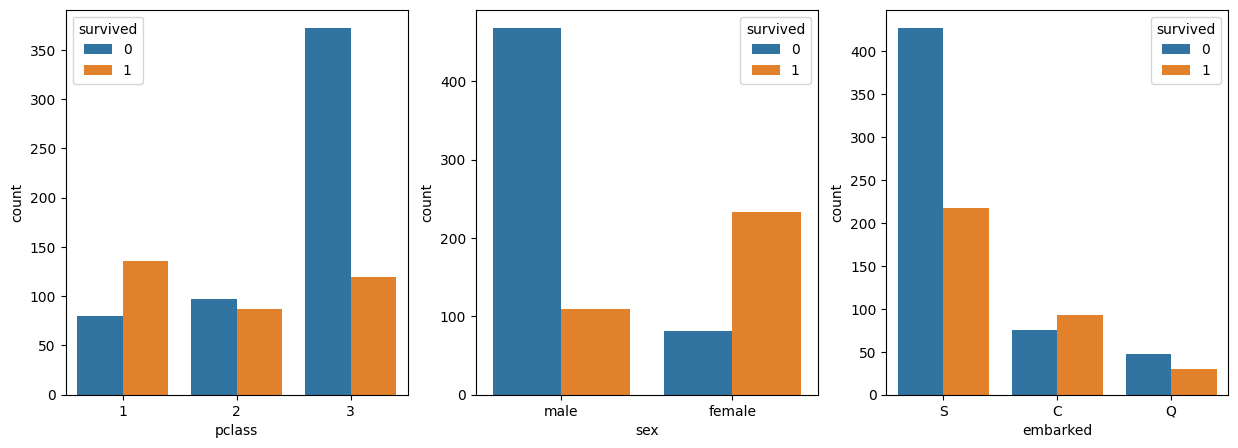

In [ ]:
from matplotlib import axes
# Categorical cols

categ_cols = ['pclass', 'sex', 'embarked']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i, col in enumerate(categ_cols):
    sns.countplot(data=df, x=col, ax=axes[i], hue="survived")
plt.show()

### `Feature Engineering`

In [ ]:
# Add 1 to add the passenger himself
# sibsp: siblings & spouses
# parch: parents & childerns
df['family_size'] = df['sibsp'] + df['parch'] + 1

def is_alone(x):
  if x > 1:
    return 0
  else:
    return 1

df['is_alone'] = df['family_size'].apply(is_alone)

df[['sibsp', 'parch', 'family_size', 'is_alone']].head()

,sibsp,parch,family_size,is_alone
0,1,0,2,0
1,1,0,2,0
2,0,0,1,1
3,1,0,2,0
4,0,0,1,1


## `Split the Dataset`

In [ ]:
choosen_features = ["pclass", "sex", "age", "sibsp", "parch", "family_size", "is_alone", "fare", "embarked"]
x = df[choosen_features]
y = df['survived']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True, random_state=42, stratify=y)


In [ ]:
# Check shapes
print("X_train shape", x_train.shape)
print("y_train shape", y_train.shape)
print()
print("X_test shape", x_test.shape)
print("y_test shape", y_test.shape)

X_train shape (712, 9)
y_train shape (712,)

X_test shape (179, 9)
y_test shape (179,)


### `Preprocessing`

In [ ]:
# Let me divide into 3 subsets
num_cols = ["age", "fare"]
categ_cols = ["sex", "embarked"]
ready_cols = list(set(x_train.columns.tolist()) - set(num_cols) - set(categ_cols))

print("Numerical cols: ", num_cols)
print("Categorical cols: ", categ_cols)
print("Ready cols: ", ready_cols)

Numerical cols:  ['age', 'fare']
Categorical cols:  ['sex', 'embarked']
Ready cols:  ['pclass', 'is_alone', 'parch', 'family_size', 'sibsp']


In [ ]:
# Numerical pipeline
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline
categ_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'))
])

# Ready pipeline
ready_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

# Combine all
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('categ', categ_pipeline, categ_cols),
    ('ready', ready_pipeline, ready_cols)
])

# Apply to all data
x_train_final = preprocessor.fit_transform(x_train)
x_test_final = preprocessor.transform(x_test)

In [ ]:
# Check shapes again
print("x_train_final shape", x_train_final.shape)
print("y_train shape", y_train.shape)
print()
print("x_test_final shape", x_test_final.shape)
print("y_test shape", y_test.shape)

x_train_final shape (712, 10)
y_train shape (712,)

x_test_final shape (179, 10)
y_test shape (179,)


In [ ]:
MODELS_FOLDER_PATH = os.path.join(os.getcwd(), "models")
os.makedirs(MODELS_FOLDER_PATH, exist_ok=True)
joblib.dump(preprocessor, os.path.join(MODELS_FOLDER_PATH, "preprocessor.joblib"))

['/content/models/preprocessor.joblib']

--------------------------

## `Basic NN Model`

In [ ]:
x_train_final.shape[1]

10

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[x_train_final.shape[1]]),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(x_train_final, y_train,
                    epochs=100, batch_size=32, validation_split=0.2)

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.6150 - loss: 0.6406 - val_accuracy: 0.6434 - val_loss: 0.5977
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6760 - loss: 0.5801 - val_accuracy: 0.7343 - val_loss: 0.5650
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7440 - loss: 0.5227 - val_accuracy: 0.7552 - val_loss: 0.5225
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7519 - loss: 0.5015 - val_accuracy: 0.7902 - val_loss: 0.4890
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.7867 - loss: 0.4769 - val_accuracy: 0.7972 - val_loss: 0.4717
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7870 - loss: 0.4917 - val_accuracy: 0.8112 - val_loss: 0.4580
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8149 - loss: 0.4471 - val_accuracy: 0.7902 - val_loss: 0.4648
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8037 - loss: 0.4424 - val_accuracy: 0.

In [ ]:
test_loss, test_acc = model.evaluate(x_test_final, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8062 - loss: 0.5572 
Test accuracy: 0.8044692873954773
Test loss: 0.5989512801170349


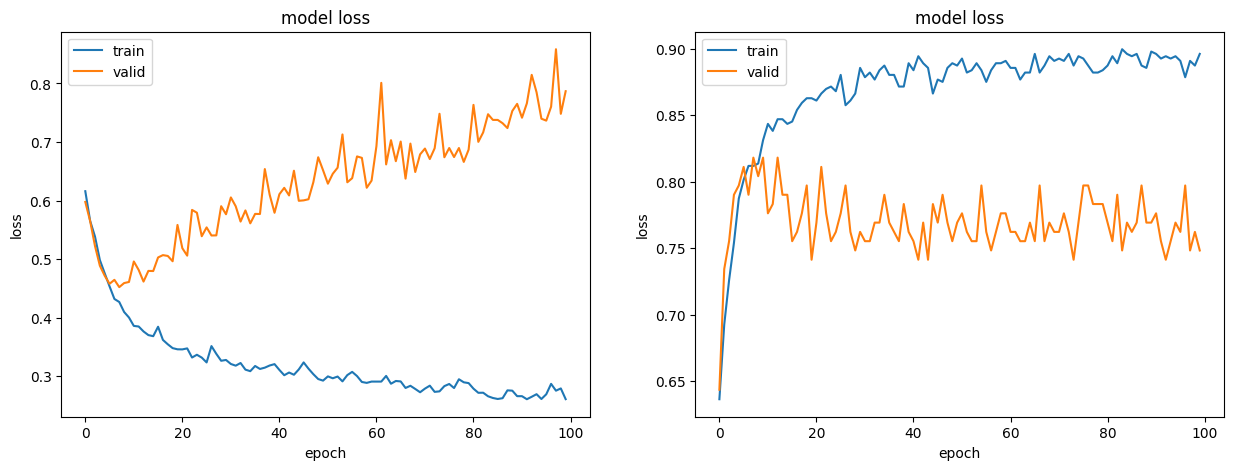

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()

plt.show()

## `Enhancing Model`

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=[x_train_final.shape[1]]),
    tf.keras.layers.Dropout(0.5, seed=2005),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=2005),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=2005),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5, seed=2005),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Model compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history = model.fit(x_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.5907 - loss: 0.7273 - val_accuracy: 0.5944 - val_loss: 0.6819
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5540 - loss: 0.7383 - val_accuracy: 0.5944 - val_loss: 0.6796
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5460 - loss: 0.6919 - val_accuracy: 0.5944 - val_loss: 0.6777
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5955 - loss: 0.6772 - val_accuracy: 0.5944 - val_loss: 0.6665
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6148 - loss: 0.6775 - val_accuracy: 0.5944 - val_loss: 0.6546
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6414 - loss: 0.6158 - val_accuracy: 0.6014 - val_loss: 0.6395
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5985 - loss: 0.6622 - val_accuracy: 0.6014 - val_loss: 0.6445
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6117 - loss: 0.6494 - val_accuracy: 0.6014 - 

In [ ]:
test_loss, test_acc = model.evaluate(x_test_final, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8047 - loss: 0.4818 
Test accuracy: 0.8156424760818481
Test loss: 0.47550877928733826


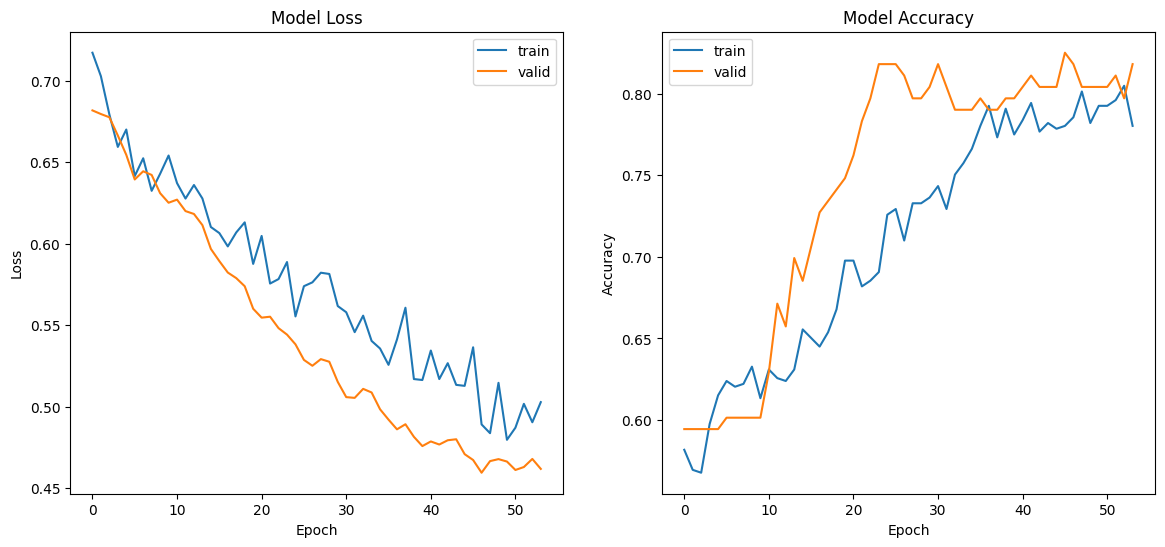

In [ ]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Enhancing the Model`

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(x_train_final.shape[1],), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer='l2'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

# Fit
history = model.fit(x_train_final, y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                    callbacks=[early_stopping])

Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.6025 - loss: 1.3737 - val_accuracy: 0.6503 - val_loss: 1.2479
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.6852 - loss: 1.1926 - val_accuracy: 0.7483 - val_loss: 1.1242
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7153 - loss: 1.0904 - val_accuracy: 0.7273 - val_loss: 1.0159
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7660 - loss: 0.9718 - val_accuracy: 0.7552 - val_loss: 0.9287
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7692 - loss: 0.9077 - val_accuracy: 0.7832 - val_loss: 0.8467
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8244 - loss: 0.7919 - val_accuracy: 0.7972 - val_loss: 0.7942
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8366 - loss: 0.7530 - val_accuracy: 0.7902 - val_loss: 0.7642
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8213 - loss: 0.7071 - val_accuracy: 0.7972 - 

In [ ]:
total_loss, total_acc = model.evaluate(x_test_final, y_test)
print('Test accuracy:', total_acc)
print('Test loss:', total_loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7960 - loss: 0.5603 
Test accuracy: 0.8100558519363403
Test loss: 0.5603781938552856


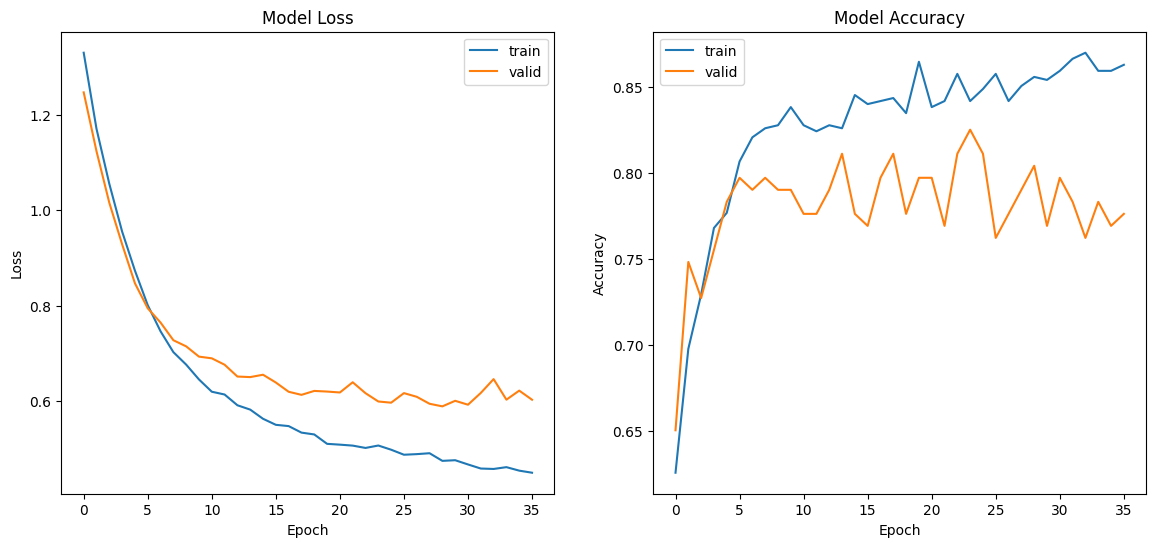

In [ ]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Using Keras-Tuner`

In [ ]:
!pip install -q keras-tuner

In [ ]:
def build_model(hp):
  model = tf.keras.models.Sequential([
      tf.keras.layers.Input(shape=(x_train_final.shape[1],)),

      tf.keras.layers.Dense(units=hp.Int("units_1", min_value=32, max_value=256, step=32),
                            activation="relu"),
      tf.keras.layers.Dropout(hp.Float("dropout_1", min_value=0.0, max_value=0.5, step=0.1)),

      tf.keras.layers.Dense(units=hp.Int("units_2",min_value=32, max_value=256, step=32),
                            activation="relu"),
      tf.keras.layers.Dropout(hp.Float("dropout_2", min_value=0.0, max_value=0.5, step=0.1)),

      tf.keras.layers.Dense(1, activation="sigmoid")
  ])

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss="binary_crossentropy", metrics=['accuracy'])

  return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [ ]:
tuner = RandomSearch(hypermodel=build_model,
                     objective="val_accuracy",
                     max_trials=10,
                     ## executions_per_trial=2,  # This parameter is not included because it is not supported in Keras Tuner version 1.4.8
                     directory="hyperparam_tuning",
                     project_name="titanic_project",
                     seed=2005)

In [ ]:
import keras_tuner
print(keras_tuner.__version__)


1.4.8


In [ ]:
tuner.search(x_train_final, y_train,
             epochs=50, validation_split=0.2,
             callbacks=[early_stopping],
             )

Trial 10 Complete [00h 00m 08s]
val_accuracy: 0.8251748085021973

Best val_accuracy So Far: 0.8321678042411804
Total elapsed time: 00h 01m 09s


In [ ]:
# Getting the best model configuration
best_model = tuner.get_best_models(num_models=1)[0]
best_model

/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<Sequential name=sequential, built=True>

In [ ]:
test_loss, test_acc = best_model.evaluate(x_test_final, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7908 - loss: 0.4502  
Test accuracy: 0.7988826632499695
Test loss: 0.4413762390613556


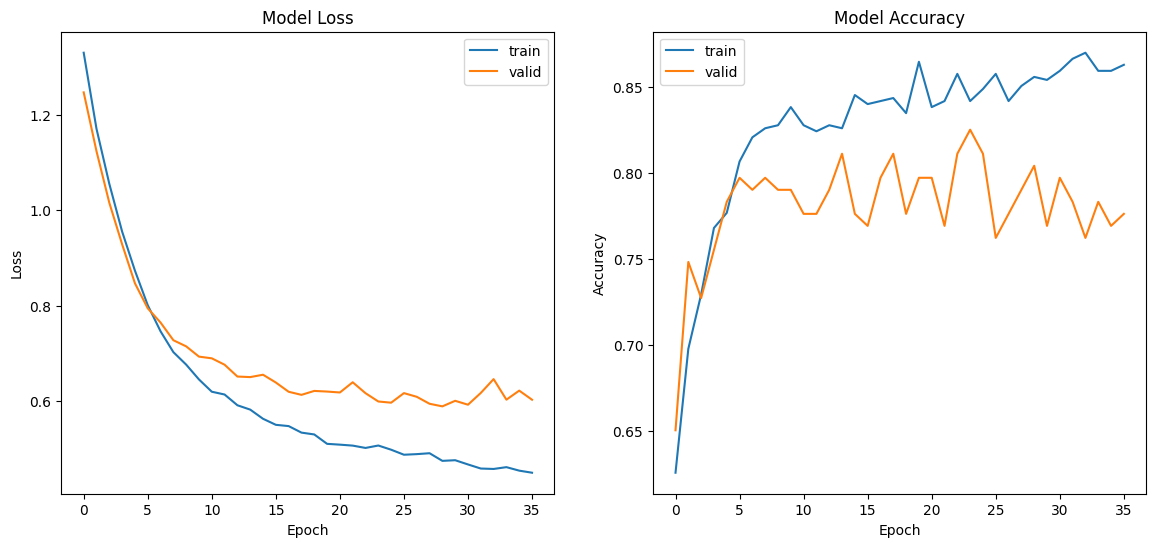

In [ ]:
# Visulalize history
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(ax[0])
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.sca(ax[1])
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## `Save & Load the Best Model`

In [ ]:
# Saving the best model from hyperparameter tuning to a file
best_model.save(os.path.join(MODELS_FOLDER_PATH, "best_titanic_model.keras"))

In [ ]:
model = tf.keras.models.load_model(os.path.join(MODELS_FOLDER_PATH, "best_titanic_model.keras"))
#
# Evaluate on test
test_loss, test_acc = best_model.evaluate(x_test_final, y_test)
print('Test accuracy:', test_acc)
print('Test loss:', test_loss)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7908 - loss: 0.4502 
Test accuracy: 0.7988826632499695
Test loss: 0.4413762390613556


/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## `Inference`

In [ ]:
df.sample(10)

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,family_size,is_alone
522,523,0,3,"Lahoud, Mr. Sarkis",male,NaN,0,0,2624,7.2250,NaN,C,1,1
83,84,0,1,"Carrau, Mr. Francisco M",male,28.0,0,0,113059,47.1000,NaN,S,1,1
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C,3,0
851,852,0,3,"Svensson, Mr. Johan",male,74.0,0,0,347060,7.7750,NaN,S,1,1
608,609,1,2,"Laroche, Mrs. Joseph (Juliette Marie Louise La...",female,22.0,1,2,SC/Paris 2123,41.5792,NaN,C,4,0
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.0000,C23 C25 C27,S,6,0
458,459,1,2,"Toomey, Miss. Ellen",female,50.0,0,0,F.C.C. 13531,10.5000,NaN,S,1,1
309,310,1,1,"Francatelli, Miss. Laura Mabel",female,30.0,0,0,PC 17485,56.9292,E36,C,1,1
42,43,0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,349253,7.8958,NaN,C,1,1
536,537,0,1,"Butt, Major. Archibald Willingham",male,45.0,0,0,113050,26.5500,B38,S,1,1


In [ ]:
samples = df.sample(10, random_state=42)
samples_processed = preprocessor.transform(samples)
predictions = (model.predict(samples_processed) > 0.5).astype("int32")
predictions.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step


array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1], dtype=int32)

In [ ]:
results = pd.DataFrame({
    'Passenger_ID': samples["passengerid"],
    'Predicted': ['Survived' if pred == 1 else 'Not Survived' for pred in predictions.flatten()],
})

results

,Passenger_ID,Predicted
709,710,Not Survived
439,440,Not Survived
840,841,Not Survived
720,721,Survived
39,40,Survived
290,291,Survived
300,301,Survived
333,334,Not Survived
208,209,Survived
136,137,Survived


NameError: name 'df' is not defined